# Prototype notebook to reconstruct all PETRIC data

## Imports

In [680]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.optimize as sci
from numba import njit
import os
import sys
import sirf.STIR as STIR #the main reconstructor
import scipy.ndimage as ndi # used to do some processing on the images
STIR.AcquisitionData.set_storage_scheme('memory')

In [690]:
# path of the folder containing all the needed input data
data_path = '/mnt/share/petric/NeuroLF_Hoffman_Dataset'

In [691]:
STIR.set_verbosity(1)

## Manual re-implementation of the computation of the Relative difference prior

The gradient is not needed unless the image is allowed to contain negative numbers

At the moment I cannot find a way to computed the step size directly in STIR (could be quite useful)

### Gradient calculation

In [692]:
def rdp_grad (inpImm_,kappa_,eps_,pixS_):
    rdpG_ = np.zeros_like(inpImm_)
    for xs in range(-1,2):
        for ys in range (-1,2):
            for zs in range(-1,2):
                if (xs == 0) and (ys==0) and (zs==0): 
                    print('continuing')
                    continue
                shiftImm_ = np.roll(inpImm_,(zs,xs,ys),axis=(0,1,2))
                sk_ = np.roll(kappa_,(zs,xs,ys),axis=(0,1,2))
                if zs==-1:
                    shiftImm_[-1,:,:]= inpImm_[-1,:,:]
                if zs==1:
                    shiftImm_[0,:,:] = inpImm_[0,:,:]

                tempW = pixS_[1]*kappa_*sk_ / np.sqrt((zs*pixS_[0])**2+(xs*pixS_[1])**2+(ys*pixS_[2])**2)             
                rdpG_ += tempW*(inpImm_ - shiftImm_)*(inpImm_ + 3 * shiftImm_ + 2* eps_ + 2* np.abs(inpImm_-shiftImm_)) /(np.abs(inpImm_)+ np.abs(shiftImm_) + 2*np.abs(inpImm_-shiftImm_ )+eps_)** 2 
    return rdpG_
    


### Step size calculation

In [693]:
def rdp_step_size (inpImm_,sDir_,kappa_,eps_,pixS_,alpha_=0):
    ssNum = 0
    ssDen = 0
   # denImm_ = inpImm_ + alpha * sDir_
    for xs in range(-1,2):
        for ys in range (-1,2):
            for zs in range(-1,2):
                if (xs == 0) and (ys==0) and (zs==0): 
    #                print('continuing')
                    continue
                shiftImm_ = np.roll(inpImm_,(zs,xs,ys),axis=(0,1,2))
                shiftSI_ = np.roll(sDir_,(zs,xs,ys),axis=(0,1,2))                
                sk_ = np.roll(kappa_,(zs,xs,ys),axis=(0,1,2))
                if zs==-1:
                    shiftImm_[-1,:,:]= inpImm_[-1,:,:]
                    shiftSI_[-1,:,:] = sDir_[-1,:,:]
                if zs==1:
                    shiftImm_[0,:,:] = inpImm_[0,:,:]
                    shiftSI_[0,:,:] = sDir_[0,:,:]
                wI = 1/(np.abs(inpImm_)+ np.abs(shiftImm_) + alpha_ * (sDir_ + shiftSI_) + 2 * np.abs(inpImm_-shiftImm_+ alpha_ * (sDir_ - shiftSI_)) + eps_)
                wI *= pixS_[1]*kappa_*sk_ / np.sqrt((zs*pixS_[0])**2+(xs*pixS_[1])**2+(ys*pixS_[2])**2)
                ssNum -= np.matmul((inpImm_-shiftImm_).flatten().T,((sDir_-shiftSI_)*wI).flat)
                ssDen += np.matmul((shiftSI_-sDir_).flatten().T,((shiftSI_-sDir_)*wI).flat)
    return ssNum,ssDen

### Value calculation (not often needed)

In [694]:
def rdp_value (inpImm_,kappa_,eps_,pixS_):
    val=0
    for xs in range(-1,2):
        for ys in range (-1,2):
            for zs in range(-1,2):
                if (xs == 0) and (ys==0) and (zs==0): 
    #                print('continuing')
                    continue
                shiftImm_ = np.roll(inpImm_,(zs,xs,ys),axis=(0,1,2))    
                sk_ = np.roll(kappa_,(zs,xs,ys),axis=(0,1,2))
                if zs==-1:
                    shiftImm_[-1,:,:]= inpImm_[-1,:,:]     
                if zs==1:
                    shiftImm_[0,:,:] = inpImm_[0,:,:]
                wI = 1/(np.abs(inpImm_) + np.abs(shiftImm_)  + 2 * np.abs(inpImm_-shiftImm_) + eps_)
                wI *= pixS_[1]*kappa_*sk_ / np.sqrt((zs*pixS_[0])**2+(xs*pixS_[1])**2+(ys*pixS_[2])**2)
                val += np.sum(np.sum(np.sum( (inpImm_-shiftImm_)**2 * wI ,axis=-1),axis=-1),axis=-1)
        return val

# STIR Setup

Load the image, smooth it lightly, and zero it when its value is low (hopefully it speeds up convergence?)

Also loads the reference image to plot convergence later

In [696]:
image = STIR.ImageData(os.path.join(data_path, 'OSEM_image.hv'))
inpImage = image.as_array()
inpImage = ndi.gaussian_filter(inpImage,0.75)
penEps = inpImage.max()*1e-3
inpImage[inpImage<(10*penEps)]=0
image.fill(inpImage)
refImm = STIR.ImageData('/workdir/refs/NeuroLF_Hoffman/reference_image.hv')

In [697]:
kappa = STIR.ImageData(os.path.join(data_path, 'kappa.hv'))

## Set up the relative difference prior computed by STIR

In [698]:
stir_prior = STIR.CudaRelativeDifferencePrior()

In [699]:
stir_prior.set_epsilon(image.max()*1e-3)
stir_prior.set_penalisation_factor(1/700)
stir_prior.set_kappa(kappa)
stir_prior.set_up(image)

## Set up the acquisition model

1. Read the sinogram, the starting image and the corrections. Set them upn in an acquisitionModel
2. To compute the step size, define a model without additive corrections. If one declares an independent one, it duplicate memory use. By using get_linear_acquisition_model() RAM is not wasted


In [700]:
acq_model = STIR.AcquisitionModelUsingParallelproj()
template = STIR.AcquisitionData(os.path.join(data_path, 'prompts.hs'))
multCorr = STIR.AcquisitionData(os.path.join(data_path,'mult_factors.hs'))
addCorr = STIR.AcquisitionData(os.path.join(data_path,'additive_term.hs'))

rMax = addCorr.max()*1e-6
addCorr +=rMax
acq_model.set_acquisition_sensitivity(STIR.AcquisitionSensitivityModel(multCorr))
acq_model.set_additive_term(addCorr)
acq_model.set_up(template, image)
ss_model = acq_model.get_linear_acquisition_model()


INFO: Interfile warning: I did not recognise the scanner from 'originating_system' (NeuroLF_15mm). Hopefully there is enough information present. I will check this now.

INFO: Interfile parsing ended up with the following scanner:
Scanner parameters:=
  Scanner type := NeuroLF_15mm
  Number of rings                          := 48
  Number of detectors per ring             := 256
  Inner ring diameter (cm)                 := 26.8
  Average depth of interaction (cm)        := 0.826007
  Distance between rings (cm)              := 0.3313
  Default bin size (cm)                    := 0.16565
  View offset (degrees)                    := -178.143
  Maximum number of non-arc-corrected bins := 180
  Default number of arc-corrected bins     := 180
  Energy resolution         := 0.25
  Reference energy (in keV) := 511
  Number of blocks per bucket in transaxial direction         := 4
  Number of blocks per bucket in axial direction              := 6
  Number of crystals per block in axial dire

# My Preconditioner

(BP (1/\bar{y} (FP(1)))

Open issue: do we really need FP(1)? It takes an extra forward projection! (\bar{y} at least gets reused)

1. Save my diagonal preconditioner in SIRF format (to be used when doing diagonal preconditioning)
2. Save its square root in np format (to be used when doing diagonal + filter)

In [701]:


fwdProj = acq_model.forward(image)
fp1 = ss_model.forward(image.get_uniform_copy(1))

myK = acq_model.backward(fp1/fwdProj)
myKsqroot = np.sqrt(myK.as_array()+1e-10)


# Recon loop

Recon with preconditioned, maybe conjugate gradient descent

## Version 1: Strictly positive, (conjugate) diagonal precondition

It's conjugate if conjugateFlag is True

Generally always works much better. With long numbers of iterations it should be useful to "reset" from time to time. But we're aiming at using like 2 or 3 iterations so not an issue

betaPen =1/700 and penEps = 1e-3 * max are given by organizers

In [932]:
from scipy.optimize import minimize

#@njit
def L(alfa,y,y_bar,fp_sdir):
    
    #y_bar_next=np.abs(y_bar+alfa*fp_sdir) +0.0001
    y_bar_next               =  y_bar+alfa*fp_sdir
    y_bar_next[y_bar_next<=0]=0.1
    
    return np.sum(y*np.log(y_bar_next) - y_bar_next)
    
def R(alfa,x_old,kappa_,eps_,pixS_,sdir):
    
    R=0
    x_next             =  x_old+alfa*sdir
    x_next[x_next<=0]=0
    for xs in range(-1,2):
        for ys in range (-1,2):
            for zs in range(-1,2):
                
                if (xs == 0) and (ys==0) and (zs==0): 
                    continue
                    
                x_shift    = np.roll(x_next,(zs,xs,ys),axis=(0,1,2)) 
                sk_        = np.roll(kappa_,(zs,xs,ys),axis=(0,1,2))
                
                if zs==-1:
                    x_shift[-1,:,:]   =x_next[-1,:,:]
          
                    
                if zs==1:
                    x_shift[0,:,:] = x_next[0,:,:]

                f     = x_next - x_shift
                g     = x_next + x_shift
                
                #wI       = 1/(np.abs(x) + np.abs(x_shift)  + 2 * np.abs(x-x_shift) + eps_)
                wI       = f**2
                wI      /= g+2*np.abs(f)+eps_
                wI      *= pixS_[1]*kappa_*sk_ / np.sqrt((zs*pixS_[0])**2+(xs*pixS_[1])**2+(ys*pixS_[2])**2)
                R       += np.sum(np.sum(np.sum( wI ,axis=-1),axis=-1),axis=-1)
        return R
        
def Fun(alfa,inpImm_,kappa_,eps_,pixS_,sdir,y,y_bar,fp_sdir):
    
    return  L(alfa,y,y_bar,fp_sdir)- \
            (1/700)*R(alfa,inpImm_,kappa_,eps_,pixS_,sdir)





In [934]:

def L_grad(alfa,y,y_bar,fp_sdir):


    #y_bar_next =np.abs(y_bar+alfa*fp_sdir)+0.0001
    
    #NOT WORKING!!!
    y_bar_next               =  y_bar+alfa*fp_sdir
    y_bar_next[y_bar_next<=0]=0.1      
    
    return np.sum( (y*fp_sdir)/(y_bar_next)-fp_sdir)


def R_grad (alfa,x_old,kappa_,eps_,pixS_,sdir):
    R=0
    x_next=  x_old+alfa*sdir
    x_next[x_next<=0]=0
   
    for xs in range(-1,2):
        for ys in range (-1,2):
            for zs in range(-1,2):
                
                if (xs == 0) and (ys==0) and (zs==0): 
                    continue
                    
                x_shift    = np.roll(x_next,(zs,xs,ys),axis=(0,1,2)) 
                s_shift    = np.roll(sdir,(zs,xs,ys),axis=(0,1,2)) 
                sk_        = np.roll(kappa_,(zs,xs,ys),axis=(0,1,2))
                
                if zs==-1:
                    x_shift[-1,:,:]   =x_next[-1,:,:]
          
                    
                if zs==1:
                    x_shift[0,:,:] = x_next[0,:,:]


                f     = x_next - x_shift
                g     = x_next + x_shift
                diff_s= sdir - s_shift
                sum_s = sdir + s_shift
                
                #wI       = 2*f*diff_s*(g+2*f)-f**2*(sum_s+2*np.where(f*diff_s > 0, 1, -1))
                wI       = 2*f*diff_s*(g + np.abs(f))-f**2*(sum_s+eps_)
                
                wI      /= ( g + 2 * np.abs(f) + eps_)**2
          
                
                wI      *= pixS_[1]*kappa_*sk_ / np.sqrt((zs*pixS_[0])**2+(xs*pixS_[1])**2+(ys*pixS_[2])**2)
                R       += np.sum(np.sum(np.sum(wI,axis=-1),axis=-1),axis=-1)
        return R

def Obj_grad (alfa,y,y_bar,fp_sdir, x_old,kappa_,eps_,pixS_,sdir):
      
        return L_grad(alfa,y,y_bar,fp_sdir)-\
                (1/700)*R_grad(alfa,x_old,kappa_,eps_,pixS_,sdir)


 

In [937]:
#PLOTTING
image.fill(inpImage)
acq_model.forward(image,out=fwdProj)
nIt = 3
conjugateFlag = True

recItV_V1 = np.zeros((nIt+1,) + inpImage.shape)
recItV_V1[0,:,:,:] = image.as_array()
betaPen =  1/700
penEps = 1e-3*inpImage.max()

fPsDir = template.get_uniform_copy(0)
gradI = image.get_uniform_copy(0)
pGrad = image.get_uniform_copy(0)
sDir = image.get_uniform_copy(0)

sampling=30
alfa= np.linspace(0.01,2.25 , sampling)
L_values=np.zeros((nIt,sampling))
L_grad_values=np.zeros((nIt,sampling))
R_values=np.zeros((nIt,sampling))
R_grad_values=np.zeros((nIt,sampling))
LR_grad_values=np.zeros((nIt,sampling))

ssTomo_hist=np.zeros(nIt)
ssPrior_hist=np.zeros(nIt)
ssTot_hist=np.zeros(nIt)

for itIdx in range(nIt):
    gradSino = template/fwdProj - 1
    acq_model.backward(gradSino,out=gradI) 
    pGrad = stir_prior.gradient(image)
    grad = gradI - pGrad
    sDir = grad / (myK + 1e-10) # avoid dividing by 0. BTW, myK is be definition higher than 1 so 1e-10 always trivial

    if conjugateFlag:
        if itIdx>0:
            beta = (grad-gradP).dot(sDir)/gradP.dot(prevSDir)
            sDir += beta * prevSDir 
        prevSDir = sDir.clone()
        gradP = grad.clone() 
    
    ss_model.forward(sDir,out=fPsDir) 
      
    for i in tqdm(range(alfa.size)):
        
        L_values[itIdx,i]= L(alfa[i],template.as_array().flatten(),\
                fwdProj.as_array().flatten(),\
                fPsDir.as_array().flatten())
        
          
        R_values[itIdx,i]= R(alfa[i],image.as_array(),\
                       kappa.as_array(),penEps,\
                       image.voxel_sizes(),\
                       sDir.as_array())
        
        '''
        L_grad_values[itIdx,i]= L_grad(alfa[i],template.as_array().flatten(),\
                                        fwdProj.as_array().flatten(),\
                                        fPsDir.as_array().flatten())
        
        R_grad_values[itIdx,i]= R_grad(alfa[i],image.as_array(),\
                       kappa.as_array(),penEps,\
                       image.voxel_sizes(),\
                       sDir.as_array())
        '''
        LR_grad_values[itIdx,i]=Obj_grad(alfa[i],template.as_array().flatten(),\
                                        fwdProj.as_array().flatten(),\
                                        fPsDir.as_array().flatten(),\
                                        image.as_array(),\
                                        kappa.as_array(),penEps,\
                                        image.voxel_sizes(),\
                                        sDir.as_array())
                                         
        
    #Tomo step size 
    ssNum = sDir.dot(gradI)
    ssDen = fPsDir.dot((fPsDir/fwdProj)) #*42
    ssTomo = ssNum/ssDen
    print(ssTomo)
    ssTomo_hist[itIdx]=ssTomo
    
    #Prior step size
    penSSNum, penSSDen = rdp_step_size(image.as_array(),sDir.as_array(),kappa.as_array(),penEps,image.voxel_sizes())
    ssPrior_hist[itIdx]=penSSNum/penSSDen
    
    #Total step size
    ss = (ssNum+2*betaPen*penSSNum)/(ssDen+2*betaPen*penSSDen)
    ssTot_hist[itIdx]=ss
    
    print ('it: {:d}, num: {:.1e} den: {:.1e} penNum {:.1e} penDen {:.1e}'.format(itIdx, ssNum,ssDen,2*betaPen*penSSNum,2*betaPen*penSSDen))


    image += ss*sDir    
    
    imArr = image.as_array()
    imArr[imArr<0]=0
    imArr[np.isnan(imArr)] = 0
    image.fill(imArr)

    acq_model.forward(image,out=fwdProj)

    recItV_V1[itIdx+1,:,:,:] = image.as_array()



100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:41<00:00,  1.40s/it]


2.1713238
it: 0, num: 1.1e+06 den: 5.0e+05 penNum 2.6e+04 penDen 6.8e+05


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:42<00:00,  1.42s/it]


2.4143965
it: 1, num: 5.4e+05 den: 2.2e+05 penNum 4.4e+04 penDen 4.8e+05


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:43<00:00,  1.45s/it]


1.9388305
it: 2, num: 5.1e+05 den: 2.6e+05 penNum 1.3e+05 penDen 1.0e+06


In [938]:
show_it=0


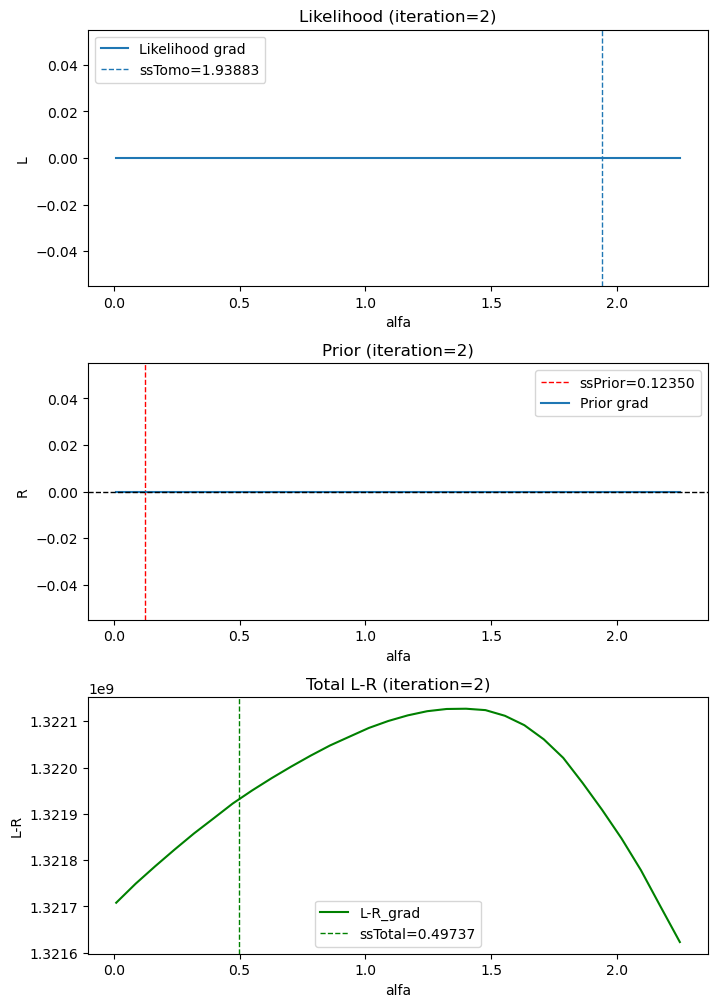

In [941]:

show_it=show_it%nIt

fig, axs = plt.subplots(3, 1, figsize=(8, 12))
plt.subplots_adjust(hspace=0.3) 

#axs[0].plot(alfa,L_values[show_it,:],label='Likelihood')
axs[0].plot(alfa,L_grad_values[show_it,:],label='Likelihood grad')
#axs[0].axhline(y=0, linestyle='--',color='black', linewidth=1)
axs[0].axvline(x=ssTomo_hist[show_it], linestyle='--', linewidth=1, label=f'ssTomo={ssTomo_hist[show_it]:.5f}')
axs[0].legend()
axs[0].set_title(f'Likelihood (iteration={show_it})')
#axs[0].set_xlim([1.4,1.55])
#axs[0].set_ylim([-1e7,0.5e7])
axs[0].set_xlabel('alfa')
axs[0].set_ylabel('L')



#axs[1].plot(alfa,R_values[show_it,:],color='red',label='prior')
axs[1].axvline(x=ssPrior_hist[show_it],color='red', linestyle='--', linewidth=1, label=f'ssPrior={ssPrior_hist[show_it]:.5f}')

axs[1].plot(alfa,R_grad_values[show_it,:],label='Prior grad')
axs[1].axhline(y=0, linestyle='--',color='black', linewidth=1)

axs[1].legend() 
axs[1].set_title(f'Prior (iteration={show_it})')
axs[1].set_xlabel('alfa')
#axs[1].set_xlim([0,0.9])
#axs[1].set_ylim([2.7e8,2.85e8])
axs[1].set_ylabel('R')

axs[2].plot(alfa, L_values[show_it,:]-(1/700)*R_values[show_it,:],color='green',label='L-R_grad')
#axs[2].plot(alfa, LR_grad_values[show_it,:]-(1/700)*R_values[show_it,:],color='green',label='L-R')
axs[2].axvline(x=ssTot_hist[show_it],color='green', linestyle='--', linewidth=1, label=f'ssTotal={ssTot_hist[show_it]:.5f}')
axs[2].legend()
axs[2].set_title(f'Total L-R (iteration={show_it})')
axs[2].set_xlabel('alfa')
#axs[2].set_xlim([0,0.9])
#axs[2].set_ylim([1.235e9,1.246e9])
axs[2].set_ylabel('L-R')

show_it +=1
    

In [936]:
#STEP SIZE Computation
image.fill(inpImage)
acq_model.forward(image,out=fwdProj)
from tqdm import tqdm
nIt = 3
conjugateFlag = True



recItV_V1 = np.zeros((nIt+1,) + inpImage.shape)
recItV_V1[0,:,:,:] = image.as_array()
betaPen =  1/700
penEps = 1e-3*inpImage.max()

fPsDir = template.get_uniform_copy(0)
gradI = image.get_uniform_copy(0)
pGrad = image.get_uniform_copy(0)
sDir = image.get_uniform_copy(0)

for itIdx in range(nIt):
    # Backproject tomographic error term
    gradSino = template/fwdProj - 1
    acq_model.backward(gradSino,out=gradI) 
    # Compute gradient of penalty
    pGrad = stir_prior.gradient(image)
    grad = gradI - pGrad
    
    # Search direction is gradient divived by preconditioner
    sDir = grad / (myK + 1e-10) # avoid dividing by 0. BTW, myK is be definition higher than 1 so 1e-10 always trivial

    # Uncomment to conver to conjugate 
    # Conjugate gradient part
    if conjugateFlag:
        if itIdx>0:
            beta = (grad-gradP).dot(sDir)/gradP.dot(prevSDir)
            sDir += beta * prevSDir 
        prevSDir = sDir.clone()
        gradP = grad.clone()   


    # Tomographic step size    
    # Computing the numerator of the step size of the tomographic part,
    # potentially only on a subset of the data (or even more quickly
    ss_model.forward(sDir,out=fPsDir) #,subset_num=0,num_subsets=42) #*multCorr
    ssNum = sDir.dot(gradI)
    ssDen = fPsDir.dot((fPsDir/fwdProj)) #*42
    ssTomo = ssNum/ssDen

    # penalty step size
    penSSNum, penSSDen = rdp_step_size(image.as_array(),sDir.as_array(),kappa.as_array(),penEps,image.voxel_sizes())
    # Full step size
    ss = (ssNum+2*betaPen*penSSNum)/(ssDen+2*betaPen*penSSDen)
    '''
    L_zero = root_scalar(L_grad, args=(template.as_array().flatten(),\
                                        fwdProj.as_array().flatten(),\
                                        fPsDir.as_array().flatten()),\
                                        bracket=[0.0, 2],method='brentq',)
 
    print(L_zero)
    '''
    '''
    st_time=time.time()
    P_zero = root_scalar(R_grad,args=(image.as_array(),\
                                       kappa.as_array(),penEps,\
                                       image.voxel_sizes(),\
                                       sDir.as_array()),\
                                       bracket=[0.1,1],method='brentq',\
                                       xtol=0.01, maxiter=20)
    print(f'time for root finding = {time.time()-st_time:.2f}')                          
    print(P_zero)
    '''
    st_time=time.time()
    L_P_zero = root_scalar(Obj_grad,args=(template.as_array().flatten(),\
                                        fwdProj.as_array().flatten(),\
                                        fPsDir.as_array().flatten(),\
                                        image.as_array(),\
                                        kappa.as_array(),penEps,\
                                        image.voxel_sizes(),\
                                        sDir.as_array()),\
                                        bracket=[0.1,2],method='brentq',\
                                        xtol=0.01, maxiter=20)
    print(f'time for root finding = {time.time()-st_time:.2f}')                          
    print(L_P_zero)
  
    
    #print(f'ss: {ss:.4e}, ss_min: {ss_min:.4e}')


    image += ss*sDir    

    # Cut negative values
    imArr = image.as_array()
    imArr[imArr<0]=0
    imArr[np.isnan(imArr)] = 0
    image.fill(imArr)

    # Update current estimate of sinogram
    acq_model.forward(image,out=fwdProj)

    recItV_V1[itIdx+1,:,:,:] = image.as_array()
    

time for root finding = 3.21
      converged: True
           flag: converged
 function_calls: 10
     iterations: 9
           root: 1.5059655238400202
         method: brentq
time for root finding = 3.21
      converged: True
           flag: converged
 function_calls: 10
     iterations: 9
           root: 1.5260559058823344
         method: brentq
time for root finding = 2.63
      converged: True
           flag: converged
 function_calls: 8
     iterations: 7
           root: 1.241396036272472
         method: brentq


In [438]:
image.fill(inpImage)
acq_model.forward(image,out=fwdProj)

In [459]:
#ORIGINAL VERSION

nIt = 1
conjugateFlag = True

recItV_V2 = np.zeros((nIt+1,) + inpImage.shape)
recItV_V2[0,:,:,:] = image.as_array()
betaPen =  1/700
penEps = 1e-3*inpImage.max()

fPsDir = template.get_uniform_copy(0)
gradI = image.get_uniform_copy(0)
pGrad = image.get_uniform_copy(0)
sDir = image.get_uniform_copy(0)

for itIdx in range(nIt):
    gradSino = template/fwdProj - 1
    acq_model.backward(gradSino,out=gradI) 
    pGrad = stir_prior.gradient(image)
    grad = gradI - pGrad
    sDir = grad / (myK + 1e-10) # avoid dividing by 0. BTW, myK is be definition higher than 1 so 1e-10 always trivial

    if conjugateFlag:
        if itIdx>0:
            beta = (grad-gradP).dot(sDir)/gradP.dot(prevSDir)
            sDir += beta * prevSDir 
        prevSDir = sDir.clone()
        gradP = grad.clone() 
    
    ss_model.forward(sDir,out=fPsDir) 
      
    #Tomo step size 
    ssNum = sDir.dot(gradI)
    ssDen = fPsDir.dot((fPsDir/fwdProj)) #*42
    ssTomo = ssNum/ssDen
    ssTomo_hist[itIdx]=ssTomo
    
    #Prior step size
    penSSNum, penSSDen = rdp_step_size(image.as_array(),sDir.as_array(),kappa.as_array(),penEps,image.voxel_sizes())
    ssPrior_hist[itIdx]=penSSNum/penSSDen
    
    #Total step size
    ss = (ssNum+2*betaPen*penSSNum)/(ssDen+2*betaPen*penSSDen)
    ssTot_hist[itIdx]=ss
    
    print ('it: {:d}, num: {:.1e} den: {:.1e} penNum {:.1e} penDen {:.1e}'.format(itIdx, ssNum,ssDen,2*betaPen*penSSNum,2*betaPen*penSSDen))


    image += ss*sDir    
    
    imArr = image.as_array()
    imArr[imArr<0]=0
    imArr[np.isnan(imArr)] = 0
    image.fill(imArr)

    acq_model.forward(image,out=fwdProj)

    recItV_V2[itIdx+1,:,:,:] = image.as_array()


it: 0, num: 5.1e+03 den: 6.3e+04 penNum 1.6e+06 penDen 2.0e+07


## Version 2: Strictly positive, diagonal + filter preconditioner

Here what we're doing is Fessler suggestion of sqrt(diagPrec) * ramp-like filtering * sqrt(diagPrec)
Notice that we can't filter in STIR (it seems) so we need to copy in an array, filter, re-put in stir. (lots of overhead in time)

Rest is as before

It's conjugate if conjugateFlag is True

Generally always works much better. With long numbers of iterations it should be useful to "reset" from time to time. But we're aiming at using like 2 or 3 iterations so not an issue

betaPen =1/700 and penEps = 1e-3 * max are given by organizers

In [62]:
image.fill(inpImage)
acq_model.forward(image,out=fwdProj)

In [63]:
nIt = 10
conjugateFlag = True

recItV_V2 = np.zeros((nIt+1,) + inpImage.shape)
recItV_V2[0,:,:,:] = image.as_array()
betaPen =  1/700
penEps = 1e-3*inpImage.max()

fPsDir = template.get_uniform_copy(0)
gradI = image.get_uniform_copy(0)
pGrad = image.get_uniform_copy(0)
sDir = image.get_uniform_copy(0)

for itIdx in range(nIt):

    gradSino = template/fwdProj - 1
    acq_model.backward(gradSino,out=gradI) #*multCorr)
    pGrad = stir_prior.gradient(image)
    grad = gradI - pGrad

    # Filter part
    gradArr = grad.as_array()
    # apply square root of diagonal prec
    gradArr /= (myKsqroot)
    gradArr *= maskSmooth
    # Convert in fourier and apply the 2D filter in the axial planes
    gradArr = np.fft.fft2(gradArr,axes=(1,2))
    gradArr *= myFilt
    gradArr = np.real(np.fft.ifft2(gradArr,axes=(1,2)))
    # smooth lightly over the z direction
    gradArr = ndi.gaussian_filter(gradArr,(0.5,0,0))
    # apply diagonal preconditioner
    gradArr /= myKsqroot
    gradArr *= maskSmooth
    # put the results in the STIR array
    sDir.fill(gradArr*mask)

    # Uncomment to conver to conjugate 
    if conjugateFlag:
        if itIdx>0:
            beta = (grad-gradP).dot(sDir)/gradP.dot(prevSDir)
            sDir += beta * prevSDir 
        prevSDir = sDir.clone()
        gradP = grad.clone()   

    # Tomographic step size
    ss_model.forward(sDir,out=fPsDir) 
    ssNum = sDir.dot(gradI)
    ssDen = fPsDir.dot((fPsDir/fwdProj))
    ssTomo = ssNum/ssDen
    # penalty step size
    penSSNum, penSSDen = rdp_step_size(image.as_array(),sDir.as_array(),kappa.as_array(),penEps,image.voxel_sizes())
    ss = (ssNum+2*betaPen*penSSNum)/(ssDen+2*betaPen*penSSDen)
    print ('it: {:d}, num: {:.1e} den: {:.1e} penNum {:.1e} penDen {:.1e}'.format(itIdx, ssNum,ssDen,2*betaPen*penSSNum,2*betaPen*penSSDen))

    # update image and sinogram
    image += ss*sDir

    # Cut negatives
    imArr = image.as_array()
    imArr[imArr<0]=0
    imArr[np.isnan(imArr)] = 0
    image.fill(imArr)
    # forward project current estimate
    acq_model.forward(image,out=fwdProj)

    recItV_V2[itIdx+1,:,:,:] = image.as_array()
    
    

it: 0, num: -1.6e+03 den: 1.3e+03 penNum 5.2e+05 penDen 4.2e+06
it: 1, num: -2.2e+03 den: 8.4e+02 penNum 2.9e+05 penDen 9.4e+05
it: 2, num: -3.7e+03 den: 2.1e+03 penNum 5.2e+05 penDen 3.4e+06
it: 3, num: -6.0e+03 den: 2.4e+03 penNum 5.3e+05 penDen 3.8e+06
it: 4, num: -7.4e+03 den: 4.2e+03 penNum 5.9e+05 penDen 3.1e+06
it: 5, num: -1.1e+04 den: 7.0e+03 penNum 6.8e+05 penDen 4.2e+06
it: 6, num: -1.3e+04 den: 9.1e+03 penNum 6.4e+05 penDen 4.1e+06
it: 7, num: -1.5e+04 den: 9.7e+03 penNum 5.4e+05 penDen 3.7e+06
it: 8, num: -1.5e+04 den: 9.5e+03 penNum 4.6e+05 penDen 3.1e+06
it: 9, num: -1.5e+04 den: 9.3e+03 penNum 4.1e+05 penDen 2.8e+06


## Version 3: allow negative values and just truncate the sinogram

For reasons it doesn't help with convergence speed! Anyway... Leave it there for now.
If one wants to introduce filter just copy from up there.

**Note how this way we are able to recycle forward projections!!**

In [266]:
image.fill(inpImage)
acq_model.forward(image,out=fwdProj)

In [267]:
nIt = 30
conjugateFlag = True

recItV_V3 = np.zeros((nIt+1,) + inpImage.shape)
recItV_V3[0,:,:,:] = image.as_array()
betaPen =  1/700
penEps = 1e-3*inpImage.max()

fPsDir = template.get_uniform_copy(0)
gradI = image.get_uniform_copy(0)
pGrad = image.get_uniform_copy(0)
sDir = image.get_uniform_copy(0)

# Non-negative denominator!
sinDenoStir = fwdProj.clone()

for itIdx in range(nIt):
    gradSino =  (template-fwdProj)/sinDenoStir
    acq_model.backward(gradSino,out=gradI) #*multCorr)

    # Need to use my re-implementation that handles negative denominators.
    pGradA = betaPen*rdp_grad(image.as_array(),kappa.as_array(),penEps,image.voxel_sizes())
    pGrad.fill(pGradA)
    grad = gradI - pGrad
    sDir = grad*maskS / (myK + 1e-10) # avoid dividing by 0. BTW, myK is be definition higher than 1

    if conjugateFlag:
        if itIdx>0:
            beta = (grad-gradP).dot(sDir)/gradP.dot(prevSDir)
            sDir += beta * prevSDir 
        prevSDir = sDir.clone()
        gradP = grad.clone()   

    ss_model.forward(sDir,out=fPsDir,subset_num=0)

    # Tomographic step size
    
    ssNum = sDir.dot(gradI)
    ssDen = fPsDir.dot((fPsDir/sinDenoStir))
    ssTomo = ssNum/ssDen
    # penalty step size
    penSSNum, penSSDen = rdp_step_size(image.as_array(),sDir.as_array(),kappa.as_array(),penEps,image.voxel_sizes())
    ss = (ssNum+2*betaPen*penSSNum)/(ssDen+2*betaPen*penSSDen)
    print ('it: {:d}, num: {:.1e} den: {:.1e} penNum {:.1e} penDen {:.1e}'.format(itIdx, ssNum,ssDen,2*betaPen*penSSNum,2*betaPen*penSSDen))

    # update image and sinogram
    image += ss*sDir
    fwdProj += ss*fPsDir

    recItV_V3[itIdx+1,:,:,:] = image.as_array()
    
    

continuing
it: 0, num: 1.4e+04 den: 6.9e+04 penNum 2.6e+06 penDen 8.1e+07
continuing
it: 1, num: -2.3e+03 den: 6.5e+04 penNum 1.7e+06 penDen 2.4e+07
continuing
it: 2, num: 4.0e+03 den: 2.0e+05 penNum 3.4e+06 penDen 7.3e+07
continuing
it: 3, num: -3.2e+04 den: 2.4e+05 penNum 3.3e+06 penDen 5.8e+07
continuing
it: 4, num: -5.1e+04 den: 4.2e+05 penNum 3.6e+06 penDen 6.5e+07
continuing
it: 5, num: -7.2e+04 den: 3.8e+05 penNum 2.9e+06 penDen 5.2e+07
continuing
it: 6, num: -8.7e+04 den: 3.3e+05 penNum 2.3e+06 penDen 3.6e+07
continuing
it: 7, num: -1.0e+05 den: 3.3e+05 penNum 2.0e+06 penDen 3.0e+07
continuing
it: 8, num: -1.2e+05 den: 3.4e+05 penNum 1.9e+06 penDen 2.7e+07
continuing
it: 9, num: -1.4e+05 den: 3.3e+05 penNum 1.7e+06 penDen 2.5e+07
continuing
it: 10, num: -1.5e+05 den: 3.3e+05 penNum 1.6e+06 penDen 2.3e+07
continuing
it: 11, num: -1.7e+05 den: 3.5e+05 penNum 1.6e+06 penDen 2.3e+07
continuing
it: 12, num: -1.9e+05 den: 3.5e+05 penNum 1.5e+06 penDen 2.3e+07
continuing
it: 13, num: 

## Version 4: allow negative values AND filter

In [272]:
image.fill(inpImage)
acq_model.forward(image,out=fwdProj)

In [273]:
nIt = 30
conjugateFlag = True

recItV_V4 = np.zeros((nIt+1,) + inpImage.shape)
recItV_V4[0,:,:,:] = image.as_array()
betaPen =  1/700
penEps = 1e-3*inpImage.max()

fPsDir = template.get_uniform_copy(0)
gradI = image.get_uniform_copy(0)
pGrad = image.get_uniform_copy(0)
sDir = image.get_uniform_copy(0)

# Non-negative denominator!
sinDenoStir = fwdProj.clone()

for itIdx in range(nIt):
    gradSino =  (template-fwdProj)/sinDenoStir
    acq_model.backward(gradSino,out=gradI) #*multCorr)

    # Need to use my re-implementation that handles negative denominators.
    pGradA = betaPen*rdp_grad(image.as_array(),kappa.as_array(),penEps,image.voxel_sizes())
    pGrad.fill(pGradA)
    grad = gradI - pGrad
    
    # Filter part
    gradArr = grad.as_array()
    # apply square root of diagonal prec
    gradArr /= (myKsqroot)
    gradArr *= maskSmooth
    # Convert in fourier and apply the 2D filter in the axial planes
    gradArr = np.fft.fft2(gradArr,axes=(1,2))
    gradArr *= myFilt
    gradArr = np.real(np.fft.ifft2(gradArr,axes=(1,2)))
    # smooth lightly over the z direction
    gradArr = ndi.gaussian_filter(gradArr,(0.5,0,0))
    # apply diagonal preconditioner
    gradArr /= myKsqroot
    gradArr *= maskSmooth
    # put the results in the STIR array
    sDir.fill(gradArr*mask)
    if conjugateFlag:
        if itIdx>0:
            beta = (grad-gradP).dot(sDir)/gradP.dot(prevSDir)
            sDir += beta * prevSDir 
        prevSDir = sDir.clone()
        gradP = grad.clone()   

    ss_model.forward(sDir,out=fPsDir,subset_num=0)

    # Tomographic step size
    
    ssNum = sDir.dot(gradI)
    ssDen = fPsDir.dot((fPsDir/sinDenoStir))
    ssTomo = ssNum/ssDen
    # penalty step size
    penSSNum, penSSDen = rdp_step_size(image.as_array(),sDir.as_array(),kappa.as_array(),penEps,image.voxel_sizes())
    ss = (ssNum+2*betaPen*penSSNum)/(ssDen+2*betaPen*penSSDen)
    print ('it: {:d}, num: {:.1e} den: {:.1e} penNum {:.1e} penDen {:.1e}'.format(itIdx, ssNum,ssDen,2*betaPen*penSSNum,2*betaPen*penSSDen))

    # update image and sinogram
    image += ss*sDir
    fwdProj += ss*fPsDir

    recItV_V4[itIdx+1,:,:,:] = image.as_array()

continuing
it: 0, num: -1.6e+03 den: 1.3e+03 penNum 5.2e+05 penDen 4.2e+06
continuing
it: 1, num: -3.1e+03 den: 1.1e+03 penNum 3.3e+05 penDen 1.1e+06
continuing
it: 2, num: -4.8e+03 den: 3.9e+03 penNum 7.3e+05 penDen 4.4e+06
continuing
it: 3, num: -8.6e+03 den: 4.0e+03 penNum 6.8e+05 penDen 3.6e+06
continuing
it: 4, num: -1.0e+04 den: 5.5e+03 penNum 6.6e+05 penDen 3.6e+06
continuing
it: 5, num: -1.1e+04 den: 5.7e+03 penNum 5.9e+05 penDen 3.4e+06
continuing
it: 6, num: -1.2e+04 den: 6.2e+03 penNum 5.2e+05 penDen 3.2e+06
continuing
it: 7, num: -1.2e+04 den: 6.0e+03 penNum 4.5e+05 penDen 2.8e+06
continuing
it: 8, num: -1.3e+04 den: 6.5e+03 penNum 4.2e+05 penDen 2.7e+06
continuing
it: 9, num: -1.3e+04 den: 6.6e+03 penNum 3.9e+05 penDen 2.5e+06
continuing
it: 10, num: -1.4e+04 den: 6.9e+03 penNum 3.7e+05 penDen 2.3e+06
continuing
it: 11, num: -1.4e+04 den: 7.2e+03 penNum 3.5e+05 penDen 2.2e+06
continuing
it: 12, num: -1.5e+04 den: 7.7e+03 penNum 3.5e+05 penDen 2.2e+06
continuing
it: 13, num

# Plot some images

# Plot convergence speed

In [461]:

#dV = np.sum(np.sum(np.sum((recItV_V1[:,:,:,:]-np.expand_dims(recImmCG,axis=0))**2,axis=-1),axis=-1),axis=-1)
#plt.plot(dV)


dV = np.sum(np.sum(np.sum((recItV_V2[:,:,:,:]-np.expand_dims(recImmCG,axis=0))**2,axis=-1),axis=-1),axis=-1)
plt.plot(dV)

#dV = np.sum(np.sum(np.sum((recItV_V3[:,:,:,:]-np.expand_dims(recImmCG,axis=0))**2,axis=-1),axis=-1),axis=-1)
#plt.plot(dV)

#dV = np.sum(np.sum(np.sum((recItV_V4[:,:,:,:]-np.expand_dims(recImmCG,axis=0))**2,axis=-1),axis=-1),axis=-1)
#plt.plot(dV)


#plt.xlim(0,10)
#plt.ylim(1,4)
#plt.plot(np.arange(0,10),10/(np.arange(1,11)))
plt.yscale('log')
plt.legend(['diag_precon','V2','V3','V4'])
plt.xlabel('N° It')
plt.ylabel('Difference norm')


ValueError: operands could not be broadcast together with shapes (2,127,200,200) (1,95,161,161) 